In [1]:
import os
from os.path import isdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

D:\Miniconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading and Reshaping Data

In [2]:
words = [word for word in os.listdir('data/train')]
command_words = sorted(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown'])


def get_fold_data(fold, words=words):
    """
    Reads in mfcc data  and labels for entire fold
    fold: 'train', 'validation', or 'test'
    words: list of words to extract
    """
    def load_word(word_name):   
        X = np.load('data/{}/{}/mfcc.npy'.format(fold, word_name))
        y = np.full(shape=X.shape[0],
                    fill_value=word_name if word_name in command_words else 'unknown')
        return X, y
    
    X_total = np.array([]).reshape(0, 20 , 32)
    y_total = np.array([])
    for word in words:
        X_word, y_word = load_word(word)
        X_total = np.vstack([X_total, X_word])
        y_total = np.append(y_total, y_word)
        
    return X_total, y_total

X_train, y_train = get_fold_data('train')
X_val, y_val = get_fold_data('validation')
X_test, y_test = get_fold_data('test')

print('Number of training samples: {}'.format(len(X_train)))
print('Number of validation samples: {}'.format(len(X_val)))
print('Number of testing samples: {}'.format(len(X_test)))
print('Shape of each sample: {}'.format(X_train[0].shape))

Number of training samples: 84843
Number of validation samples: 9981
Number of testing samples: 11005
Shape of each sample: (20, 32)


In [3]:
#holds counts of each word for each fold
word_counts = pd.DataFrame()
for fold, y in zip(['train', 'validation', 'test'], [y_train, y_val, y_test]):
    word_counts[fold] = pd.Series(y).value_counts()
word_counts = word_counts.sort_index()
word_counts

,train,validation,test
down,3134,377,406
go,3106,372,402
left,3037,352,412
no,3130,406,405
off,2970,373,402
on,3086,363,396
right,3019,363,396
stop,3111,350,411
unknown,54074,6278,6931
up,2948,350,425


In [4]:
def reformat_data(X, y):
    """
    Reshapes X into an 'image' of depth 1
    Encodes y into one hot encoded integers
    """
    X = X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = LabelEncoder().fit_transform(y)
    y = to_categorical(y)
    return X, y

_, y_train_hot = reformat_data(X_train, y_train)
_, y_val_hot = reformat_data(X_val, y_val)
_, y_test_hot = reformat_data(X_test, y_test)
    
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))

X_train shape: (84843, 20, 32)
y_train shape: (84843,)


# Single Layer Perceptron

In [5]:
opt = keras.optimizers.Adam(lr=0.0001, epsilon=10**-8)
early_stopping_monitor = EarlyStopping(patience=3)

In [6]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train[0].shape)))
model.add(Flatten())
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train, y_train_hot, batch_size=100, epochs=100, verbose=1,
          validation_data=(X_val, y_val_hot), callbacks=[early_stopping_monitor])

Train on 84843 samples, validate on 9981 samples
Epoch 1/100
84843/84843 [==============================] - 3s 38us/step - loss: 5.8987 - acc: 0.6338 - val_loss: 5.9767 - val_acc: 0.6291
Epoch 2/100
84843/84843 [==============================] - 2s 25us/step - loss: 5.8454 - acc: 0.6373 - val_loss: 5.9773 - val_acc: 0.6291
Epoch 3/100
84843/84843 [==============================] - 2s 26us/step - loss: 5.8453 - acc: 0.6373 - val_loss: 5.9799 - val_acc: 0.6290
Epoch 4/100
84843/84843 [==============================] - 2s 25us/step - loss: 5.8453 - acc: 0.6373 - val_loss: 5.9799 - val_acc: 0.6290


In [7]:
score = model.evaluate(x=X_test, y=y_test_hot)

for name, value in zip(model.metrics_names, score):
    print(name, value)

11005/11005 [==============================] - 0s 33us/step
loss 5.966844289869356
acc 0.6298046342571558


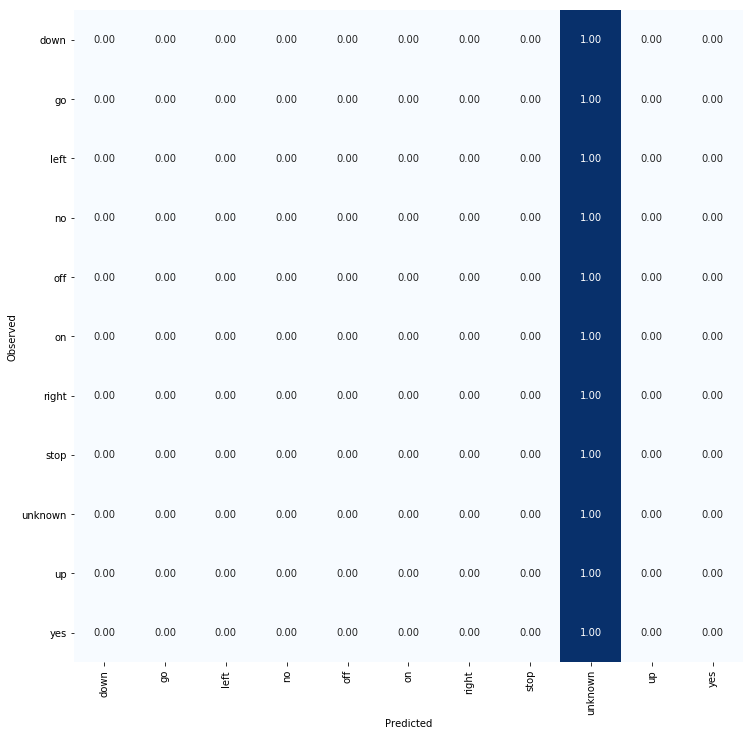

In [8]:
def plot_confusion_matrix(y_pred, y_test):
    y_pred_labels = np.array([command_words[y] for y in y_pred])
    conf_matrix = confusion_matrix(y_test, y_pred_labels)
    conf_matrix_percent = np.divide(conf_matrix.T, conf_matrix.sum(axis=1)).T
    fig, ax = plt.subplots(figsize=(12, 12))    
    sns.heatmap(conf_matrix_percent, cmap='Blues', ax=ax, annot=True, fmt='.2f', cbar=False)
    ax.set_xticklabels(command_words, rotation=90)
    ax.set_yticklabels(command_words, rotation=0)
    ax.set_ylabel('Observed')
    ax.set_xlabel('Predicted')
    plt.show()
    return conf_matrix_percent
    
y_pred_perceptron = model.predict_classes(x=X_test)
a = plot_confusion_matrix(y_pred_perceptron, y_test)

# Simple Feedforward Neural Network

In [15]:
model2 = Sequential()
model2.add(InputLayer(input_shape=(X_train[0].shape)))
model2.add(Flatten())
model2.add(Dense(50, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(11, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model2.fit(X_train, y_train_hot, batch_size=100, epochs=100, verbose=1,
          validation_data=(X_val, y_val_hot), callbacks=[early_stopping_monitor])

Train on 84843 samples, validate on 9981 samples
Epoch 1/100
84843/84843 [==============================] - 3s 32us/step - loss: 14.6587 - acc: 0.0775 - val_loss: 13.7696 - val_acc: 0.1151
Epoch 2/100
84843/84843 [==============================] - 2s 27us/step - loss: 13.3321 - acc: 0.1237 - val_loss: 12.7444 - val_acc: 0.1442
Epoch 3/100
84843/84843 [==============================] - 2s 28us/step - loss: 12.6034 - acc: 0.1505 - val_loss: 12.1363 - val_acc: 0.1636
Epoch 4/100
84843/84843 [==============================] - 2s 27us/step - loss: 9.9264 - acc: 0.2949 - val_loss: 3.8493 - val_acc: 0.5119
Epoch 5/100
84843/84843 [==============================] - 2s 27us/step - loss: 2.2455 - acc: 0.5884 - val_loss: 1.8326 - val_acc: 0.6206
Epoch 6/100
84843/84843 [==============================] - 2s 28us/step - loss: 1.7169 - acc: 0.6466 - val_loss: 1.6574 - val_acc: 0.6502
Epoch 7/100
84843/84843 [==============================] - 3s 31us/step - loss: 1.5858 - acc: 0.6722 - val_loss: 1.54

In [16]:
score = model2.evaluate(x=X_test, y=y_test_hot)

for name, value in zip(model2.metrics_names, score):
    print(name, value)

11005/11005 [==============================] - 0s 26us/step
loss 0.6957181086700269
acc 0.7980009086778737


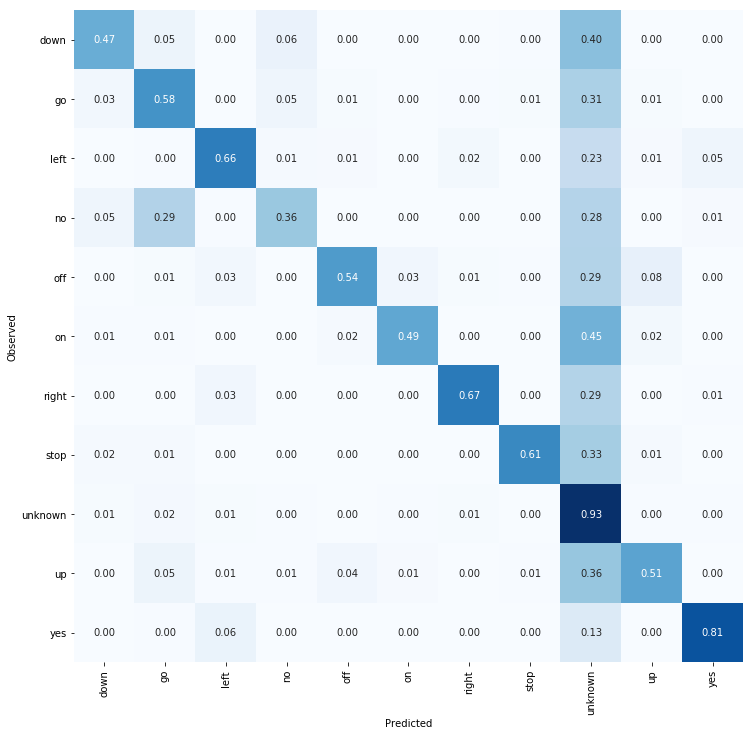

In [17]:
y_pred_ff = model2.predict_classes(x=X_test)
b = plot_confusion_matrix(y_pred_ff, y_test)